In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score
import seaborn as sns

## Import the dataset

In [3]:
df = pd.read_csv("/Users/marcodibiasi/Desktop/Programmazione/Python/dsprojects/healthcare-dataset-stroke-data.csv")

In [4]:
df.tail()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0
5109,44679,Female,44.0,0,0,Yes,Govt_job,Urban,85.28,26.2,Unknown,0


In [5]:
len(df.columns)

12

## Clean the dataset

In [6]:
df.dropna(inplace=True)

In [7]:
#take the class of each feature

wt = np.unique(df['work_type'])
rt = np.unique(df['Residence_type'])
ss = np.unique(df['smoking_status'])
gn = np.unique(df['gender'])

In [8]:
wt, rt, ss, gn

(array(['Govt_job', 'Never_worked', 'Private', 'Self-employed', 'children'],
       dtype=object),
 array(['Rural', 'Urban'], dtype=object),
 array(['Unknown', 'formerly smoked', 'never smoked', 'smokes'],
       dtype=object),
 array(['Female', 'Male', 'Other'], dtype=object))

In [9]:
#transform classes into numbers

df.work_type.replace(('Govt_job', 'Never_worked', 'Private', 'Self-employed', 'children'), range(1, 6), inplace=True)
df.ever_married.replace(('Yes', 'No'), (1, 2), inplace=True)
df.gender.replace(('Male', 'Female', 'Other'), (1, 2, 3), inplace=True)
df.Residence_type.replace(('Rural', 'Urban'), (1, 2), inplace=True)
df.smoking_status.replace(('Unknown', 'formerly smoked', 'never smoked', 'smokes'), (1, 2, 3, 4), inplace=True)

### Create two different datasets (normal and standardized)

In [10]:
X = df.iloc[:, 1:11]
y = df.iloc[:, 11]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

### Data are unbalanced, create synthetic data with SMOTE

In [12]:
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [13]:
X_std_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
X_std_test = (X_test - np.mean(X_test, axis=0)) / np.std(X_test, axis=0)

In [14]:
X_train.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,2,75.0,0,0,1,4,2,87.69,27.5,2
1,2,41.0,0,0,1,3,1,83.44,21.5,1
2,2,12.0,0,0,2,5,2,82.39,17.1,3
3,2,52.0,0,0,1,3,2,99.10,29.1,1
4,2,71.0,1,0,1,3,2,194.62,31.6,3


In [15]:
X_std_train.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,1.101816,0.914318,-0.304103,-0.243743,-0.483557,1.041673,1.298773,-0.536113,-0.275745,-0.403984
1,1.101816,-0.614646,-0.304103,-0.243743,-0.483557,0.032217,-0.769958,-0.616418,-1.170124,-1.475845
2,1.101816,-1.918763,-0.304103,-0.243743,2.068010,2.051129,1.298773,-0.636257,-1.826002,0.667877
3,1.101816,-0.119981,-0.304103,-0.243743,-0.483557,0.032217,1.298773,-0.320521,-0.037244,-1.475845
4,1.101816,0.734440,3.288356,-0.243743,-0.483557,0.032217,1.298773,1.484338,0.335414,0.667877


### Create another dataset based on correlations

In [45]:
correlations = (df.corr()['stroke'][1:11])
names = list(df.columns)

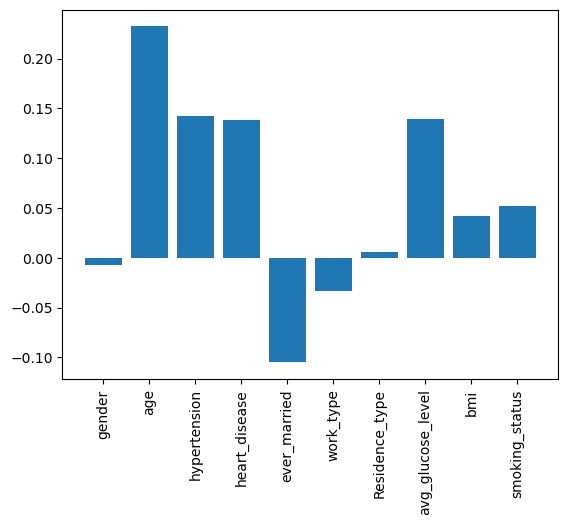

In [46]:
plt.bar(names[1:11], correlations)
plt.xticks(rotation=90)
plt.show()

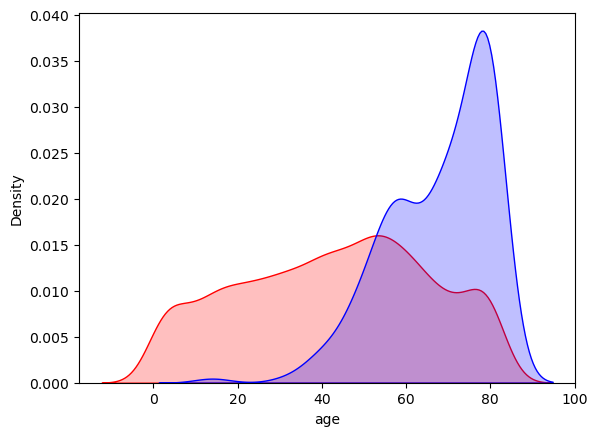

In [47]:
age = sorted(list(df["age"]))
age_rel_s = df.copy()
age_rel_s.drop(age_rel_s[age_rel_s['stroke'] == 0].index, inplace=True)
age_rel_s = age_rel_s["age"]

h_age = np.hstack(age)
fig = sns.kdeplot(age, shade=True, color='r')
fig = sns.kdeplot(age_rel_s, shade=True, color='b')
plt.show()

In [48]:
dict_correlations = dict(correlations)
X_corr_train, X_corr_test = X_train.copy(), X_test.copy()
y_corr_train, y_corr_test = y_train, y_test

In [49]:
def get_key_from_value(dictionary, val) -> str:
    return [k for k, dictionary in dictionary.items() if dictionary == val]

for feature in correlations:
    if abs(feature) < 0.04:
        to_drop = str(get_key_from_value(dict_correlations, feature))[2:-2]
        X_corr_train.drop([to_drop], axis='columns', inplace=True)
        X_corr_test.drop([to_drop], axis='columns', inplace=True)

# Train logistic regression models
### Original, standardized and correlation based datasets

In [51]:
lr = LogisticRegression(random_state=1, solver='liblinear')
lr_std = LogisticRegression(random_state=1, solver='liblinear')
lr_corr = LogisticRegression(random_state=1, solver='liblinear')

In [52]:
lr.fit(X_train, y_train)
normal_score = lr.score(X_test, y_test)
normal_score

0.756958587915818

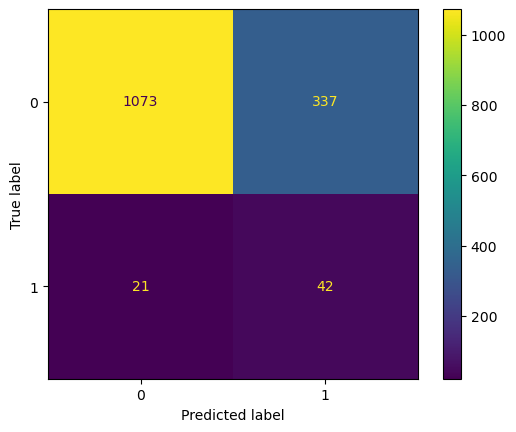

In [53]:
y_pred = lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [54]:
recall = recall_score(y_test, y_pred)
recall

0.6666666666666666

In [55]:
lr_std.fit(X_std_train, y_train)
standard_score = lr_std.score(X_std_test, y_test)
standard_score

0.5254582484725051

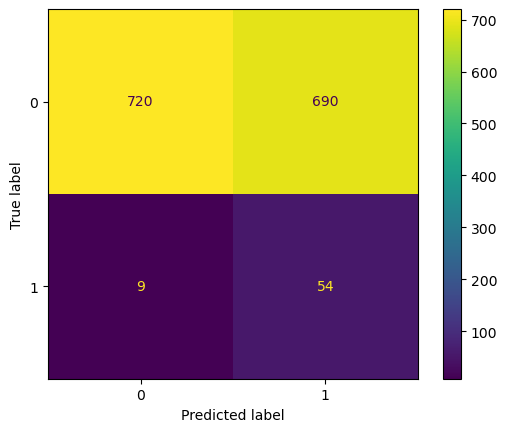

In [56]:
y_std_pred = lr_std.predict(X_std_test)
cm_std = confusion_matrix(y_test, y_std_pred)
disp_std = ConfusionMatrixDisplay(confusion_matrix=cm_std)
disp_std.plot()
plt.show()

In [57]:
recall_std = recall_score(y_test, y_std_pred)
recall_std

0.8571428571428571

In [58]:
lr_corr.fit(X_corr_train, y_corr_train)
correlation_score = lr_corr.score(X_corr_test, y_corr_test)
correlation_score

0.7040054310930075

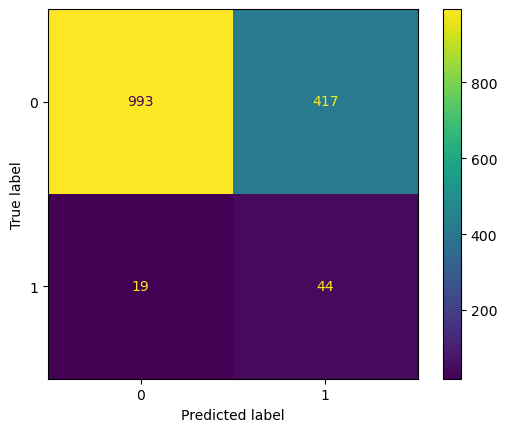

In [59]:
y_corr_pred = lr_corr.predict(X_corr_test)
cm_corr = confusion_matrix(y_corr_test, y_corr_pred)
disp_corr = ConfusionMatrixDisplay(confusion_matrix=cm_corr)
disp_corr.plot()
plt.show()

In [60]:
recall_corr = recall_score(y_corr_test, y_corr_pred)
recall_corr

0.6984126984126984